# Lab session: classification

The goal of this lab session is for you to get a good grasp of data cleaning, clustering, classification implementations and evaluations. For this reason, the lab is less focused on re-implementing existing algorithms, and more onto using what is already available and making sense of it. We have tried to write as much of the code that requires prior knowledge of the librairies, so that you can focus on exploration and data mining itself.

Here are some handy links for reference:

* [Lecture slides: data exploration and cleaning](https://ecampus.paris-saclay.fr/course/view.php?id=30869#section-0)
* [Lecture slides: classification](https://ecampus.paris-saclay.fr/course/view.php?id=30869#section-1)
* [pandas documentation](https://pandas.pydata.org/docs/index.html)
* [scikit-learn documentation](https://scikit-learn.org/stable/index.html)

As a general tip, in Jupyter notebooks you can suffix a function with "?" to get its documentation, and with "??" to get its source code. This is immensely useful to check input variables, parameters, etc.

```python

>>> max?
Docstring:
max(iterable, *[, default=obj, key=func]) -> value
max(arg1, arg2, *args, *[, key=func]) -> value

With a single iterable argument, return its biggest item. The
default keyword-only argument specifies an object to return if
the provided iterable is empty.
With two or more arguments, return the largest argument.
Type:      builtin_function_or_method

```

In [50]:
max?

Docstring:
max(iterable, *[, default=obj, key=func]) -> value
max(arg1, arg2, *args, *[, key=func]) -> value

With a single iterable argument, return its biggest item. The
default keyword-only argument specifies an object to return if
the provided iterable is empty.
With two or more arguments, return the largest argument.
Type:      builtin_function_or_method


Let us make our imports and get started.

In [2]:
!pip install sklearn
!pip install seaborn

import sklearn as sk
import numpy as np
from sklearn import cluster
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

You should consider upgrading via the 'C:\Users\Augustin\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Augustin\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
%matplotlib inline

## The Palmer Penguin dataset

Let us look at the [Palmer penguins]() dataset. It is a small dataset that contains measurements about real-world penguins. The files `penguins_lter.csv` and `penguins_size.csv` contain different attributes. We will start using only one of them.

Our task is to:

   - Do an exploratory analysis of the data
   - Think about what algorithms and features we want to use, and how we need to transform our variables
   - Run our algorithms and evaluate them

In [4]:
penguins_cs = pd.read_csv(open("data/penguins_size.csv"))

### Exploratory analysis

The goal of this first section is to get an idea of how the data is structured and distributed. We should keep in mind the things we have see during the lecture:

* Are the different attributes distributed in very different spans of values? Will it be a problem for the models we wish to use?
* How do we want to address different spans (if relevant?)
* Which attributes are numeric/categorical/etc.?
* Do we have "Non assigned" values? What should we do with them?

_Tip: It would be a good idea to make different copies of your original data (for example using the `data.copy()` function), in order to compare different strategies: normalising versus not normalising, normalisation versus standardisation etc._


In [6]:
penguins_cs.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [17]:
penguins_cs

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


In [7]:
penguins_cs.columns

Index(['species', 'island', 'culmen_length_mm', 'culmen_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex'],
      dtype='object')

Plot two attributes against each other, two see how correlated they are. Explore the different variables and their distributions, to get an idea of how the data is distributed and which attributes are relevant.

_Tip: Given two lists `x` and `y`, you can make a scatter plot with `plt.plot(x, y, 'o')`. You can use `data["attribute"].hist()` to get the attribute's distribution._

Text(0, 0.5, 'depth')

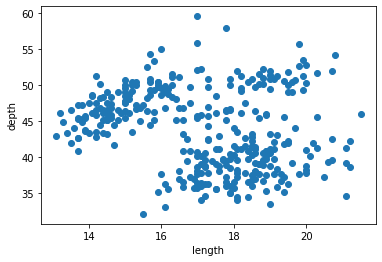

In [5]:
plt.plot(penguins_cs["culmen_depth_mm"], penguins_cs["culmen_length_mm"], 'o');
plt.xlabel("length")
plt.ylabel("depth")

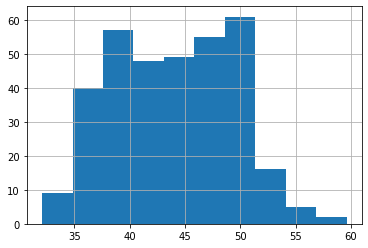

In [9]:
penguins_cs['culmen_length_mm'].hist();

Now let us handle missing values. Should we treat all missing values the same way? What fraction of the data would we remove, if we were to drop all the lines  that have at least one missing value?

_Tip: look into the [`data.dropna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) function provided by pandas. In particular, notice that using the `how` and `thres` arguments, you can have a fine-grained treatment of missing values, for example removing rows that have more than 50% missing columns, but filling the values yourself otherwise._

In [18]:
penguins_cs = penguins_cs.dropna()

In [23]:
penguins_cs

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,FEMALE
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


**Quick check:** did you make sure the penguins' sex attribute was clean, and had coherent values as well as non-NaN values?

In [45]:
penguins_cs[(penguins_cs["sex"] != "MALE") & (penguins_cs["sex"] != "FEMALE")]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


Let us write code to normalize and standardize our attributes, if we wish to do so. Each function takes as input a `Series` (i.e. a column from the dataframe), and returns a new, modified `Series`.

_Tip: functions can be applied pointwise to `DataFrames` and `Series`, without the need for an explicit `for` loop._

In [34]:
def normalize(data: pd.Series):
    # Write code here
    norm_data = (data - data.min())/(data.max()-data.min());
    return norm_data


def standardize(data: pd.Series):
    # Write code here
    stand_data = (data - data.mean())/(data.std());
    
    return stand_data

In [33]:
normalize(penguins_cs['culmen_depth_mm'])

0      0.666667
1      0.511905
2      0.583333
4      0.738095
5      0.892857
         ...   
338    0.071429
340    0.142857
341    0.309524
342    0.202381
343    0.357143
Name: culmen_depth_mm, Length: 334, dtype: float64

In [35]:
standardize(penguins_cs['culmen_depth_mm'])

0      0.782313
1      0.121713
2      0.426605
4      1.087205
5      1.747804
         ...   
338   -1.758454
340   -1.453562
341   -0.742147
342   -1.199486
343   -0.538886
Name: culmen_depth_mm, Length: 334, dtype: float64

_Tip: you can apply a function easily to a whole Series or DataFrame, using `pd.apply()`_

We finally provide you with a modified version of the dataframe, that contains only numerical values. You might not necessarily need it.

In [38]:
penguins_num = penguins_cs[['culmen_length_mm', 'culmen_depth_mm',
       'flipper_length_mm', 'body_mass_g']]
penguins_num = penguins_num.fillna(0)

In [41]:
penguins_norm = penguins_num.apply(normalize)
penguins_stand = penguins_num.apply(standardize)

## Classification

While we have not seen any classification algorithms in class yet, let us try to classify (instead of cluster) our data. The code for the classification algorithm is already completely written out for you, so you can focus on the other tasks.

Start by choosing what you want to classify on (for example, the species). You can use the exploratory data analysis you did before to guide your choice.

### Preparation

In [49]:
sample = penguins_cs.sample(frac=0.85)



In [51]:
pd.concat([sample, penguins_cs]).drop_duplicates(keep=False)


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
16,Adelie,Torgersen,38.7,19.0,195.0,3450.0,FEMALE
21,Adelie,Biscoe,37.7,18.7,180.0,3600.0,MALE
22,Adelie,Biscoe,35.9,19.2,189.0,3800.0,FEMALE
25,Adelie,Biscoe,35.3,18.9,187.0,3800.0,FEMALE
34,Adelie,Dream,36.4,17.0,195.0,3325.0,FEMALE
43,Adelie,Dream,44.1,19.7,196.0,4400.0,MALE
48,Adelie,Dream,36.0,17.9,190.0,3450.0,FEMALE
54,Adelie,Biscoe,34.5,18.1,187.0,2900.0,FEMALE
66,Adelie,Biscoe,35.5,16.2,195.0,3350.0,FEMALE
69,Adelie,Torgersen,41.8,19.4,198.0,4450.0,MALE


First, write down a function that will split your data into train and test datasets. Since we are in a controlled environment, we will not use an extra validation dataset, in order to make the most of the data we have. The header of the function is written out for you: `data` is the DataFrame you want to split into train and test, `target_key` is the attribute you wish to predict (for example, the species); the `percent_test` tells you the fraction of the data that should be used for testing, and defaults at 15%.

The function returns 4 objects: `X_train` contains the features for learning on the train dataset, and `y_train` is the target attribute. Likewise for `X_test` and `y_test`.

_Tip: to slice a dataframe like you would with a Python list, you can use the [.iloc]() function as follows: `data.iloc[row_slice, col_slice]`_

_Tip: to shuffle a dataframe, you can use `df = df.sample(frac=1)`_

_Tip: to remove a column from a dataframe, you can use `dr.drop(col_name, axis=1)`_

In [90]:
def train_test_split(data: pd.DataFrame, target_key:str, percent_test: int =15):
    # Write code here
    data_train = data.sample(frac= (1-(percent_test/100)))
    data_test = pd.concat([data, data_train]).drop_duplicates(keep=False)
    
    
    X_train = data_train.drop(target_key, axis=1)
    y_train = data_train[target_key]
    
    X_test = data_test.drop(target_key, axis=1)
    y_test = data_test[target_key]
    
    return X_train, y_train, X_test, y_test

data = penguins_cs.copy()
data["species"] = LabelEncoder().fit_transform(data["species"])
data["island"] = LabelEncoder().fit_transform(data["island"])
data["sex"] = LabelEncoder().fit_transform(data["sex"])

X_train, y_train, X_test, y_test = train_test_split(data, target_key= "sex",percent_test=10)

The few lines below can help you check that you train and test sets have the same dimension, and that the test set roughly corresponds to the `percent_test` that we provided.

In [91]:
print(f"y_train and X_train have the same length ({len(y_train)}, {len(X_train)}): {len(y_train) == len(X_train)}")
print(f"y_test and X_test have the same length ({len(y_test)}, {len(X_test)}): {len(y_test) == len(X_test)}")
print(f"Percentage of the dataset used for test: {round(len(y_test)/(len(y_test)+len(y_train))*100, 2)} %")

y_train and X_train have the same length (301, 301): True
y_test and X_test have the same length (33, 33): True
Percentage of the dataset used for test: 9.88 %


Check that your train and test set are appropriate. For example, is the repartition of the target variable similar? If not, how could you correct this issue?

In [83]:
y_train.describe()


count    224.000000
mean       0.937500
std        0.896243
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: species, dtype: float64

In [84]:
y_test.describe()

count    110.000000
mean       0.890909
std        0.881465
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: species, dtype: float64

## Simple models

Majority vote and $k$-nearest neighbours.

In [162]:
class MajorityClassifier():
    def __init__(self):
        self.majorityClass = None
    
    def fit(self, X, y):
        # Write code that will find the majority class in 
        # X, y and will set the class attribute accordingly
        # Tip: you do not need X in this case
        self.majorityClass = y.value_counts().idxmax()
        
        return # This function does not need to return anything
    
    def predict(self, X):
        preds = []
        
        try:
            if self.majorityClass is None:
                raise(ValueError)
        except ValueError:
            print("ValueError: Cannot predict on an unfitted model. Run fit() on your train data first.")
            
        preds= [self.majorityClass for i in range(X.shape[0])]
        # Write prediction code here: we predict the majority class for everyone3
        
        
        return preds

Now test your majority classifier on the penguin dataset.

In [163]:
mc = MajorityClassifier()
mc.fit(X_train, y_train)
mc_preds = mc.predict(X_test)
mc_preds


[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

Let us continue with a slightly more complex classifier, the $k$-nearest neighbours one. **As a bonus**, you can recode it (filling in the code below), but you can also use `scikit-learn`'s implementation.

In [27]:
class kNNClassifier():
    def __init__(self, k: int = 2):
        self.k = k
    
    def get_closest_points(self, x: pd.Series):
        closest_points = []
        
        return closest_points
    
    def fit(self, X: pd.DataFrame, y):
        # In the basic k-NN, there is no need for a training phase.
        # You can ignore this function.
        # In the more advanced k-NN, you can write the hashing code here.
        
        
        return # This function does not need to return anything
    
    def predict(self, X: pd.DataFrame):
        # Write code that will find the k closest points from each data point.
        # For this, you need first to compute the distances from every point to every other.
        # Then, find the k closest points, and predict the majority class.
    
        preds = []
        
        
        return preds

In [100]:
# Use custom implementation
# knn = kNNClassifier(k=3)

# Use sklearn's implementation
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)

### Building a decision tree

In [101]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)

In [102]:
list(X_train.columns)

['species',
 'island',
 'culmen_length_mm',
 'culmen_depth_mm',
 'flipper_length_mm',
 'body_mass_g']

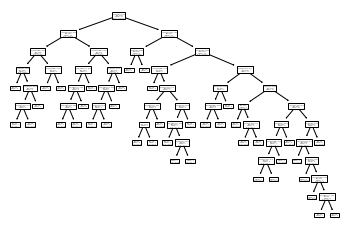

In [103]:
plt.Figure(figsize=(12,12))
plot_tree(dt, feature_names=list(X_train.columns));
plt.show()

### Training a Random Forest

In [1]:
# Simple random forest code, add some tuning : n trees, max depth (make forcefully shallow trees), min_samples?
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, max_depth)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

SyntaxError: positional argument follows keyword argument (1787799282.py, line 4)

### Training Support Vector Machines

In [110]:
# Add some tuning considerations

from sklearn.svm import SVC

svm = SVC(kernel="linear")
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)

## Evaluation

Now it is time to focus on the evaluation of our models. Let us use this as an opportunity to compare the clustering and classification approaches.

   - How can we evaluate the quality of the classification model? Think about the ranking agreement metrics we saw in the first lecture
   - Can we look at the confusion matrix outputted by our classification algorithm?
   - What is the impact of normalization/standardization?
   - How can we evaluate the quality of the classification? You can go read again about the F1-score and ROC curves

In [112]:
from sklearn.metrics import f1_score, roc_curve

In [151]:
mc_preds

[]

In [164]:
f1_score(np.array(y_test), np.array(mc_preds), average="micro")

0.5151515151515151

Let us evaluate our `kNN` model. Go back to the model, and in particular play with the number of trees (parameter `n_neighbors`) -- see how the classification changes with different values of $k$, and how the computation time is impacted. To get a high-level view, you could, for example, plot the $F_1$-score as a function of each parameter. Which parameters make the most sense? How do they impact the classification performance?

In [165]:
f1_score(np.array(y_test), np.array(knn_preds), average="micro")

0.7575757575757576

Let us evaluate our `DecisionTree` model. Go back to the model, and in particular play with the maximum depth of the tree (parameter `max_depth`), and the number of samples per leaf node (parameter `min_samples_split`). To get a high-level view, you could, for example, plot the $F_1$-score as a function of each parameter. You could also look at different confusion matrices (see below), to get an idea of how some models underfit or overfit.

In [166]:
f1_score(np.array(y_test), np.array(dt_preds), average="micro")

0.8787878787878788

Let us evaluate our `RandomForest` model. Go back to the model, and in particular play with the number of trees (parameter `n_estimators`), the maximum depth of the trees (parameter `max_depth`), and the number of samples per leaf node (parameter `min_samples_split`). To get a high-level view, you could, for example, plot the $F_1$-score as a function of each parameter. You could also look at different confusion matrices (see below), to get an idea of how some models underfit or overfit.

In [167]:
f1_score(np.array(y_test), np.array(rf_preds), average="micro")

0.8787878787878788

Let us evaluate our `SVM` model. Go back to the model, and in particular play with the regularization cost (parameter `C`), and the kernel to be used (parameter `kernel`, which can take values `'linear', 'rbf', 'polynomial'`), and the degree of the polynomial kernel (parameter `degree`). To get a high-level view, you could, for example, plot the $F_1$-score as a function of each parameter. Which parameters make the most sense? How do they impact the classification performance?

In [117]:
f1_score(np.array(y_test), np.array(svm_preds), average="micro")

0.8787878787878788

Using the code below, plot the ROC curves for your models. Be careful, the ROC curve **only makes sense for binary classification**. You can predict the penguin's sex, which in this dataset is a binary class. Based on the ROC curve, how good is the model?

Text(0, 0.5, 'true positive rate')

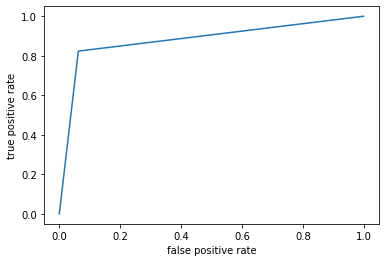

In [119]:
fpr, tpr, _ = roc_curve(y_test, rf_preds, pos_label=1)
plt.plot(tpr, fpr);
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

In [124]:
y_test.array

<PandasArray>
[2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1,
 2, 2, 1, 1, 2, 2, 1]
Length: 33, dtype: int32

Using the code below, plot the confusion matrix for your models.

In [144]:
def get_confusion_matrix(y_test, y_pred):
    # Write code that computes the confusion matrix
    # from the y_test and y_pred arrays.
    # creation 1ere ligne: le pingouin est un mâle.
    y1 = y_test.array
    y2 = y_pred
    
    # comp =y_test.compare(y_pred)
    # false1 = comp.at.value_counts()
    
    n = len(y_test)
    
    c11 =0;
    c21 =0;
    c12 =0;
    c22=0;
    
    for k in range(n) :
        
        print(k);
        x1 = y1[k]
        x2 = y2[k]

        
        print(x1,x2);
        
        if x1 == 1:
            
            if x2 == x1 :
                
                c11 +=1;
            else :
                
                c12 +=1;
        else:
            
            if x2 == x1 :
                
                c22 +=1;
            else :
                
                c21 +=1;
                
    cm = np.array([[c11,c12],[c21,c22]]);
    
    return cm

# cm = get_confusion_matrix(y_test, rf_preds);

In [142]:
y_test

13     2
20     1
33     2
37     1
40     1
50     1
53     2
61     2
86     2
102    1
107    2
117    2
118    1
119    2
120    1
128    1
138    1
169    1
180    1
183    2
200    2
209    2
210    2
225    1
247    2
252    1
255    2
259    2
262    1
272    1
301    2
319    2
332    1
Name: sex, dtype: int32

0
2 2
1
1 1
2
2 2
3
1 2
4
1 1
5
1 1
6
2 2
7
2 2
8
2 1
9
1 1
10
2 2
11
2 2
12
1 1
13
2 1
14
1 1
15
1 1
16
1 1
17
1 1
18
1 1
19
2 2
20
2 1
21
2 2
22
2 2
23
1 1
24
2 2
25
1 1
26
2 2
27
2 2
28
1 1
29
1 1
30
2 2
31
2 2
32
1 1


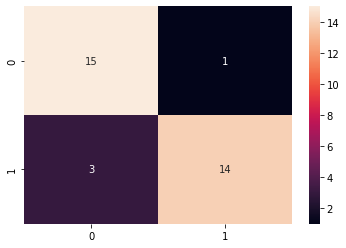

In [145]:

df_cm = pd.DataFrame(get_confusion_matrix(y_test, rf_preds), range(len(cm)), range(len(cm)))
sn.heatmap(df_cm, annot=True)

plt.show()

For each model, there are many other parameters. We focused on the ones that usually have the most impact on the prediction quality, but feel free to play around with the other ones if they are relevant to your data or use-case.

## A non-toy dataset: the "vital" pages of Wikipedia

Now that we have had the opportunity to test code and play around with a relatively simple dataset, let us consider a real-world one. The **WikiVitals (en)** dataset comprises of the 10,000 most important Wikipedia articles (articles are selected by users). We have extracted this dataset for you; it is stored in graph format for compacity, with sparse matrices storing the hyperlinks between articles as well as the words appearing in the summary of each article. Since we have not studied graphs together, we provide some helper functions to get an article's title, the words associated to each article, and its label.

The dataset should be relatively clean already (though, you are welcome to check :) ), but there is work to do to extract relevant features from the words of each article (for example, tf-idf scores through scikit-learn's [TfIdfVectorizer]()).

Some possible tasks:

* Predict the category of an article (easy)
* Predict the hierarchy of categories of an article (difficult): you might want to use a custom scoring function here, that will take into account the hierarchy while learning. Intuitively, it is not the same to confuse a cat with a tiger versus a cat with a banana.

In [ ]:
!pip install scikit-network

In [62]:
import sknetwork as skn

graph = skn.data.load_netset("wikivitals")

Parsing files...
Done.


In [63]:
graph

{'adjacency': <10011x10011 sparse matrix of type '<class 'numpy.bool_'>'
 	with 824999 stored elements in Compressed Sparse Row format>,
 'biadjacency': <10011x37845 sparse matrix of type '<class 'numpy.int64'>'
 	with 1363301 stored elements in Compressed Sparse Row format>,
 'labels': array([5, 5, 2, ..., 3, 6, 5], dtype=int64),
 'labels_hierarchy': array([ 930,  930,  534, ...,  637, 1170,  930], dtype=int64),
 'meta': {'name': 'Wikivitals (en)',
  'description': 'Vital articles of Wikipedia in English (level 4) with links between them and words used in summaries (tokenization by Spacy, model "en_core_web_lg").',
  'source': 'https://en.wikipedia.org/wiki/Wikipedia:Vital_articles/Level/4',
  'date': 'June 2021'},
 'names': array(['0', '1', '100 metres', ..., 'Łódź', 'Śāriputra', '−1'],
       dtype='<U62'),
 'names_col': array(['Alexis', 'Cairo', 'subordinate', ..., 'parody', 'martyrdom',
        'Wyler'], dtype='<U26'),
 'names_labels': array(['Arts', 'Biological and health science

In [64]:
# All articles
graph.names

array(['0', '1', '100 metres', ..., 'Łódź', 'Śāriputra', '−1'],
      dtype='<U62')

In [69]:
# All words of article i
def get_words(graph, article_id):
    i = article_id
    indptr = graph.biadjacency.indptr
    words_indices = graph.biadjacency.indices[ indptr[i] : indptr[i+1] ]
    return [ graph.names_col[w] for w in words_indices ]

# Label (i.e. Wikipedia category) of article i 
def get_label(graph, article_id):
    label_id = graph.labels[article_id] 
    
    return label_id, graph.names_labels[label_id]

words = get_words(graph, 0)
label_id, label = get_label(graph, 0)

In [70]:
label_id, label, words

(5,
 'Mathematics',
 ['from',
  'historically',
  'identity',
  'system',
  'zero',
  'for',
  'be',
  'slang',
  'naught',
  'integer',
  'or',
  'the',
  'a',
  'many',
  'fulfill',
  'in',
  'numerical',
  'to',
  'algebraic',
  'use',
  'least',
  'well',
  'role',
  'context',
  'and',
  'that',
  'where',
  'central',
  'place',
  'adjacent',
  'informal',
  'digit',
  'term',
  'US',
  'UK',
  'also',
  'of',
  'as',
  'o',
  'name',
  'represent',
  'English',
  'zip',
  'placeholder',
  'one',
  'letter',
  'value',
  'mathematic',
  'additive',
  'structure',
  'cipher',
  'have',
  'include',
  'it',
  'ought',
  'at',
  'real',
  'number',
  'numeral',
  'distinguish',
  'other'])